Putting NMF, KNN clustering, PCA and related tools to use for analyzing the fashion MNIST dataset. We want to do classification as well as regeneration. Following https://www.kaggle.com/nicw102168/trying-out-some-pca-nmf-and-knn

First we must import tensorflow's NMF module and numpy, as well as pandas for the df's, and matplotlib for the plottt. And sklearn for that sweet PCA, but will import when it is needed.

# PCA

In [35]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  


mnist_train = pd.read_csv("/Users/oliviagallup/Downloads/fashionmnist/fashion-mnist_train.csv")
mnist_test = pd.read_csv("/Users/oliviagallup/Downloads/fashionmnist/fashion-mnist_test.csv")

# mnist_train.head()

We can see that the MNIST Data has already been split into train and test. We also know that the classification of the pictures is marked from 0-9 in the first column "label". We wanna split it up therefore into input and output.

In [36]:
x_train = mnist_train.iloc[:, 1:]   # Removing the "label" column 
y_train = mnist_train.iloc[:, [0]]   # The 0 is in [] to keep df type, else y_train would be a Series :(

x_test = mnist_test.iloc[:, 1:]
y_test = mnist_test.iloc[:, [0]]

Now we have our train and test sets and we will do some PCA decomposition as an initial test.

In [37]:
from sklearn.decomposition import PCA

pca = PCA(random_state=0, whiten=True)  # Pre-processing step
pca.fit(x_train);

Now hopefully we can see what the PC's look like. We need a reshaping step to turn the 1D pixel row into a 2D picture, and luckly there's a nice .reshape function just for that purpose.

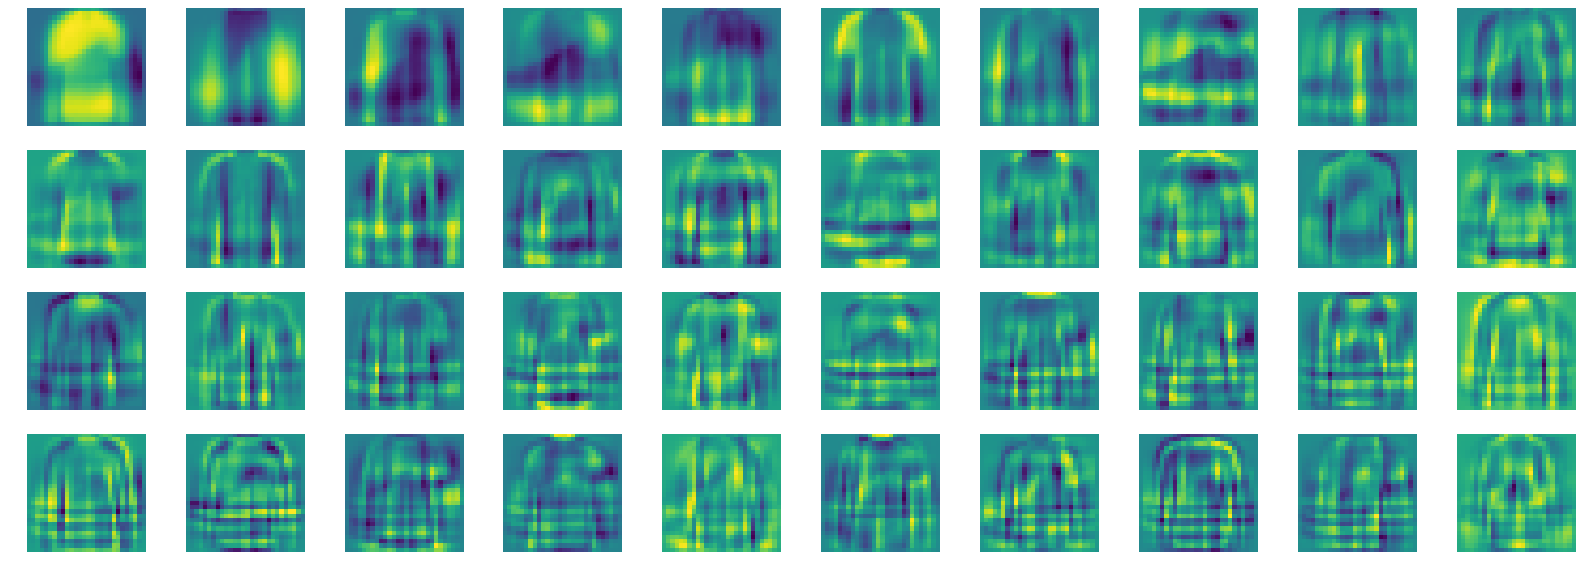

In [72]:
plt.figure(figsize=(28,10))
for k in range(40):
    plt.subplot(4,10,k+1)
    plt.imshow(pca.components_[k].reshape(28,28))
    plt.axis('off')

0kay so now we have all the principal components k. To figure out how many to keep now, one would have to calculate the variation of each and plot that on a cumulative addition graph vs. the principal component number. Take the k that has reached a sufficiently high % of the total variation. That is the variance explained by each dimension, pca.explained_variance_ratio_.

Text(0, 0.5, 'Cumulative percentage of variance explained')

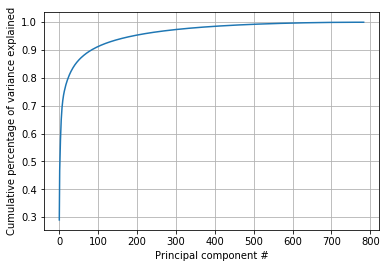

In [57]:
exp_var_cum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(exp_var_cum.size), exp_var_cum)
plt.grid()
plt.xlabel("Principal component #")
plt.ylabel("Cumulative percentage of variance explained")

Okay let's zoom in on this cumulative variance graph and see what components fall into the higher percentage area.

(0.9, 1.0)

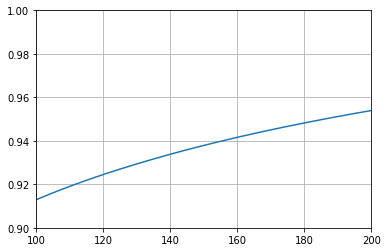

In [60]:
plt.plot(range(exp_var_cum.size), exp_var_cum)
plt.grid()
plt.xlim(100,200)
plt.ylim(0.9, 1.0)

For the principal components used to reduce the dimensions, we will use k=120 and thus be just over 92% of the dimensions accounting for all the variation in the data. To regenerate these images, we have to fit the PCA to the training data with the newly decided value of k. Then we want to transform the test data with the pca and then inverse transform it?

In [71]:
pca = PCA(n_components = 120, random_state=0, whiten=True)
pca.fit(x_train)

x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

x_test.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,9,8,0,...,103,87,56,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,14,53,99,17,...,0,0,0,0,63,53,31,0,0,0
3,0,0,0,0,0,0,0,0,0,161,...,137,126,140,0,133,224,222,56,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


So. Because the training and test data was originally extracted using dataframes for convenience, they must be turned into a reshapable type if we want to image them, specifically into a numpy.ndarray.

In [89]:
x_test_array = np.ndarray(x_test.shape)
x_test_array = x_test.values

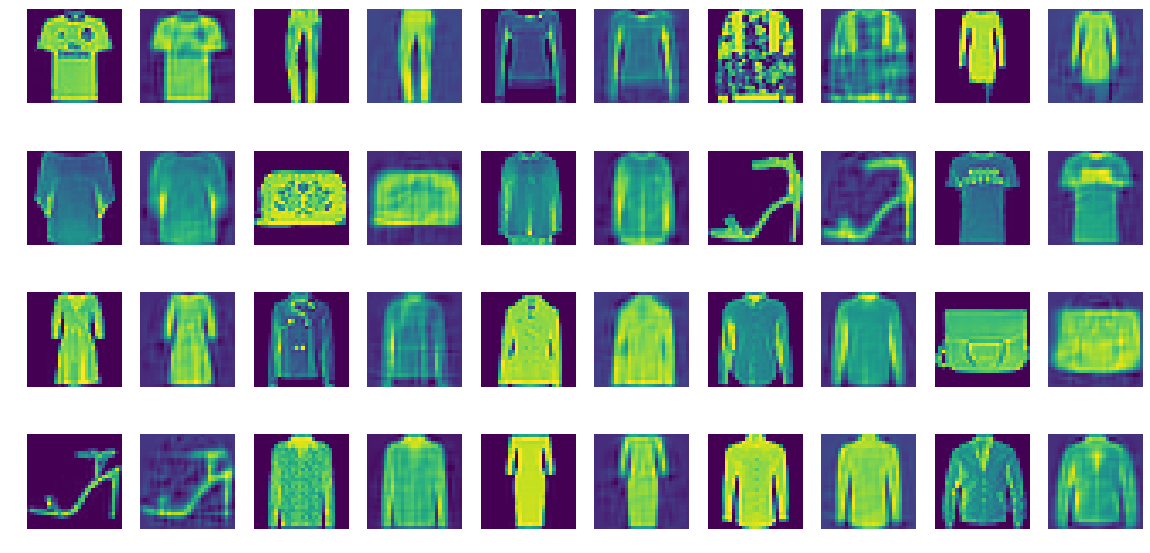

In [94]:
x_reconstructed_pca = pca.inverse_transform(x_test_pca)

plt.figure(figsize=(20,10))
for k in range(20):
    plt.subplot(4, 10, k*2 + 1)
    plt.imshow(x_test_array[k].reshape(28,28))
    plt.axis('off')
    plt.subplot(4, 10, k*2 + 2)
    plt.imshow(x_reconstructed_pca[k].reshape(28,28))
    plt.axis('off')

# NMF
Lots of details are lost, we shall try to reconstruct them with NMF or wtvr. Loading NMF from sklearn, we have to select the number of components to use with the decomposition, as well as the training size we want to use to fit the nmf (optional; you can use the full training data set as well).

In [97]:
NMF_TRAIN_SIZE = 100000   # Actually the size of our data set already, but can be varied

from sklearn.decomposition import NMF
nmf = NMF(n_components=120, random_state=0)
nmf.fit(x_train)    # The selection of the amount of data was taken out from nmf.fit(x_train[:NMF_TRAIN_SIZE]), since we're using all the data

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=120, random_state=0, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)

Cool so our NMF got trained, its W and H matrices being thicc, and these are the features it detected.

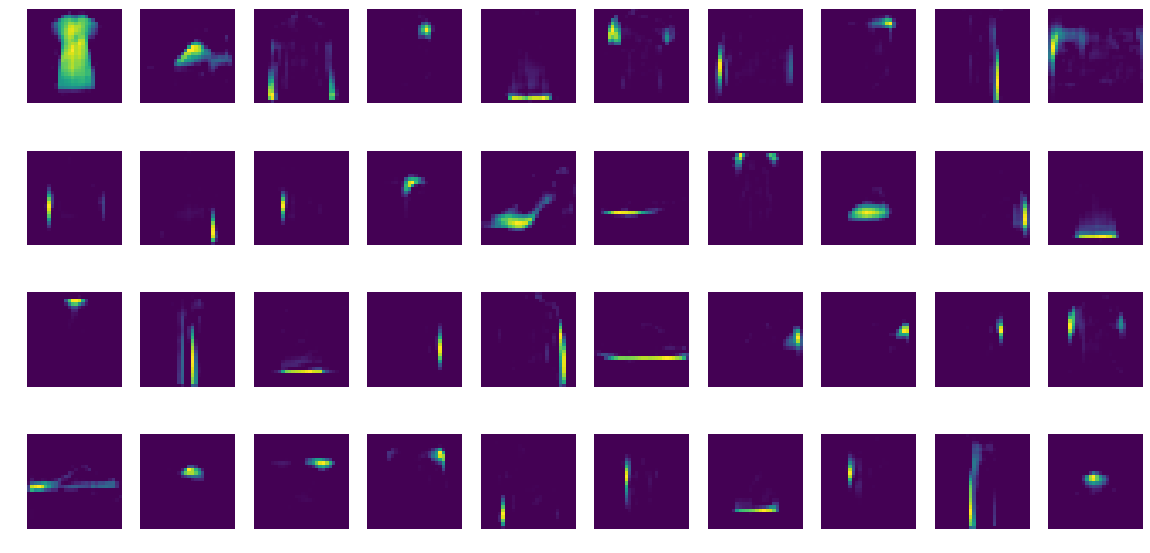

In [99]:
plt.figure(figsize=(20,10))
for k in range(40):
    plt.subplot(4, 10, k + 1)
    plt.imshow(nmf.components_[k].reshape(28,28))
    plt.axis('off')

On to the reconstruction; how good will the NMF be in reconstructing the fashion MNIST data set?

In [100]:
x_train_nmf = nmf.transform(x_train)
x_test_nmf = nmf.transform(x_test)
x_reconstructed = nmf.inverse_transform(x_test_nmf)

What's happening here is that the NMF is two matrices W and H that are approximating the input matrix: X = WH is the expression. When we apply the transform() function, we are taking the input X and turning it into W. The inverse Transform does the opposite and returns X from W. The way I think it works is the way that the tensorflow NMF implementation is described, where you dot H and W to get the reconstruction normally, so if you want to apply WH to something new, you would transform x_test for example and get a W, then if you do the inverse of this...

So the transform and inverse transform function I don't quite understand. The transform function puts out different W matrices depending on the input, and perhaps in the inverse it then reconstruct an X matrix by combining the W matrix and H' (H inverse). Perhaps in the transform function only the W is changed when the input is passed and then inverse H is used to generate the new X in the inverse transform.

Once again we have to change the type of the dataframe x_test into a numpy array.

array([[0.03085455, 0.44638279, 0.        , ..., 0.        , 1.23070766,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.48011602, ..., 0.        , 0.        ,
        0.01542099],
       ...,
       [0.        , 0.        , 0.84418247, ..., 0.93376487, 1.43972748,
        0.        ],
       [2.50083359, 0.09862407, 0.60076961, ..., 0.92061952, 1.06646774,
        0.7172557 ],
       [1.07394564, 0.36922156, 1.17734787, ..., 0.        , 1.5411641 ,
        0.        ]])

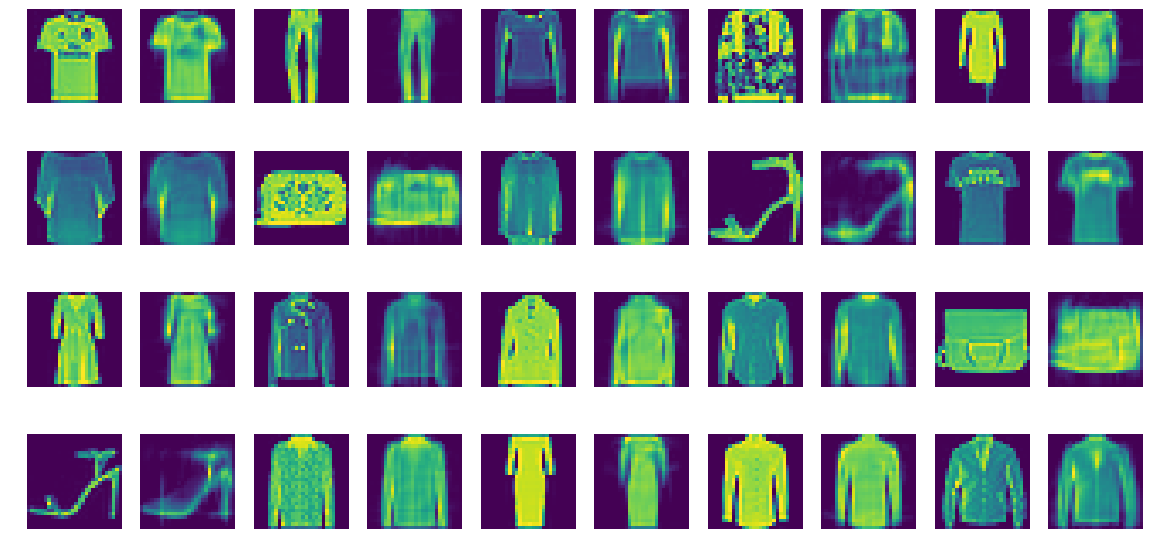

In [105]:
x_test_array = np.ndarray(x_test.shape)
x_test_array = x_test.values

plt.figure(figsize=(20,10))
for k in range(20):
    plt.subplot(4, 10, k*2 + 1)
    plt.imshow(x_test_array[k].reshape(28,28))
    plt.axis('off')
    plt.subplot(4, 10, k*2 + 2)
    plt.imshow(x_reconstructed[k].reshape(28,28))
    plt.axis('off')
    
x_train_nmf
x_test_nmf

On to some basic Classification.

# Classification

We have labels categorizing the images from 0-9 and want to train a classifier on that using tensorflow / keras. Following tutorial in https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

In [106]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [109]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Resetting the variables x and y train/test
x_train = mnist_train.iloc[:, 1:]   # Removing the "label" column 
y_train = mnist_train.iloc[:, [0]]   # The 0 is in [] to keep df type, else y_train would be a Series :(

x_test = mnist_test.iloc[:, 1:]
y_test = mnist_test.iloc[:, [0]]

Above I imported the datasets with pandas and that's it, but I could have also done it like this to overcome the whole arrays/dataframes thing: 

dataframe = pandas.read_csv("iris.csv", header=None)
dataset = dataframe.values
X = dataset[:,0:4].astype(float)
Y = dataset[:,4]

Because we have multi-class categories, we wanna transform that 0-9 classification into one-hot encoding and avoid weird number flukes. This gives us a 10 column matrix from the 1 column integer.

In [115]:
# convert integers to dummy variables (i.e. one hot encoded)
y_train_onehot = np_utils.to_categorical(y_train)
y_test_onehot = np_utils.to_categorical(y_test)


Now for some hidden layers, setting the baseline. This code is from the iris dataset tutorial which only has 4 classifications, so we have to adjust the layer numbers somewhat. 

In [116]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(18, input_dim=4, activation='relu'))    # Inner hidden layer random size lol
    model.add(Dense(10, activation='softmax'))     # The output layer that is giving us a one-hot classification
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
